# 6.5 Lab: Linear Models and Regularization Methods

In [65]:
library("ISLR2")
library("MASS")
library("ggplot2")
library("ggthemes")
library("boot")
library("skimr")
library("caret")
library("leaps")
library("glmnet")
library("pls")

# Define a color cycle to use
colors <- colorblind_pal()(8)

## 6.5.1 Subset Selection Methods

### Best Subset Selection

Here we apply the best subset selection approach to the `Hitters` data. 
We wish to predict a baseball player's `Salary` on the basis of various statistics associated with performance in the previous year.

First of all, we note that the `Salary` variable is missing for some of the players. 
The `is.na()` function can be used to identify the missing observations.
It returns a vector of the same length as the input vector, with a `TRUE` for any elements that are missing, and a `FALSE` for non-missing elements.
The `sum()` function can then be used to count all of the missing elements.

In [2]:
head(Hitters)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<dbl>,<fct>
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NA,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [3]:
skim(Hitters)

── Data Summary ────────────────────────
                           Values 
Name                       Hitters
Number of rows             322    
Number of columns          20     
_______________________           
Column type frequency:            
  factor                   3      
  numeric                  17     
________________________          
Group variables            None   

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts    
1 League                0             1 FALSE          2 A: 175, N: 147
2 Division              0             1 FALSE          2 W: 165, E: 157
3 NewLeague             0             1 FALSE          2 A: 176, N: 146

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable n_missing complete_rate    mean      sd    p0   p25    p50
 1 AtBat                 0         1      381.    153.    16   255.   380. 
 2 Hi

In [4]:
sum(is.na(Hitters$Salary))

[1] 59

Hence we see that `Salary` is missing for 59 players. 
The `na.omit()` function removes all of the rows that have missing values in any variable.

In [5]:
Hitters <- na.omit(Hitters)
dim(Hitters)

[1] 263  20

In [6]:
sum(is.na(Hitters))

[1] 0

The `regsubsets()` function (part of the `leaps` library) performs best subset selection by identifying the best model that contains a given number of predictors, where *best* is quantified using RSS. 
The syntax is the same as for `lm()`. 
The `summary()` command outputs the best set of variables for each model size.

In [7]:
regfit_full <- regsubsets(Salary ~ ., Hitters)
summary(regfit_full)

Subset selection object
Call: regsubsets.formula(Salary ~ ., Hitters)
19 Variables  (and intercept)
           Forced in Forced out
AtBat          FALSE      FALSE
Hits           FALSE      FALSE
HmRun          FALSE      FALSE
Runs           FALSE      FALSE
RBI            FALSE      FALSE
Walks          FALSE      FALSE
Years          FALSE      FALSE
CAtBat         FALSE      FALSE
CHits          FALSE      FALSE
CHmRun         FALSE      FALSE
CRuns          FALSE      FALSE
CRBI           FALSE      FALSE
CWalks         FALSE      FALSE
LeagueN        FALSE      FALSE
DivisionW      FALSE      FALSE
PutOuts        FALSE      FALSE
Assists        FALSE      FALSE
Errors         FALSE      FALSE
NewLeagueN     FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: exhaustive
         AtBat Hits HmRun Runs RBI Walks Years CAtBat CHits CHmRun CRuns CRBI
1  ( 1 ) " "   " "  " "   " "  " " " "   " "   " "    " "   " "    " "   "*" 
2  ( 1 ) " "   "*"  " "   " "  " " " "   

An asterisk indicates that a given variable is included in the corresponding model. 
For instance, this output indicates that the best two-variable model contains only `Hits` and `CRBI`. 
By default, `regsubsets()` only reports results up to the best eight-variable model. 
But the `nvmax` option can be used in order to return as many variables as are desired. 
Here we fit up to a 19-variable model.

In [8]:
reg_fit_full <- regsubsets(Salary ~ ., Hitters, nvmax = 19)
reg_summary <- summary(reg_fit_full)

The `summary()` function also returns $R^2$, RSS, adjusted $R^2$, $C_p$, and BIC. 
We can examine these to try to select the best overall model.

In [9]:
names(reg_summary)

[1] "which"  "rsq"    "rss"    "adjr2"  "cp"     "bic"    "outmat" "obj"

For instance, we see that the $R^2$ statistic increases from 32%, when only one variable is included in the model, to almost 55%, when all variables are included. 
As expected, the $R^2$ statistic increases monotonically as more variables are included.

In [10]:
round(reg_summary$rsq, 3)

[1] 0.321 0.425 0.451 0.475 0.491 0.509 0.514 0.529 0.535 0.540 0.543 0.544
[13] 0.544 0.545 0.545 0.546 0.546 0.546 0.546

Plotting RSS, adjusted $R^2$, $C_p$, and BIC for all of the models at once will help us decide which model to select. Note the `type = "l"` option tells `R` to connect the plotted points with lines.

The `points()` command works like the `plot()` command, except that it puts points on a plot that has already been created, instead of creating a new plot. 
The }which.max()` function can be used to identify the location of the maximum point of a vector. 
We will now plot a red dot to indicate the model with the largest adjusted $R^2$ statistic.

In a similar fashion we can plot the $C_p$ and BIC statistics, and indicate the models with the smallest statistic using `which.min()`.

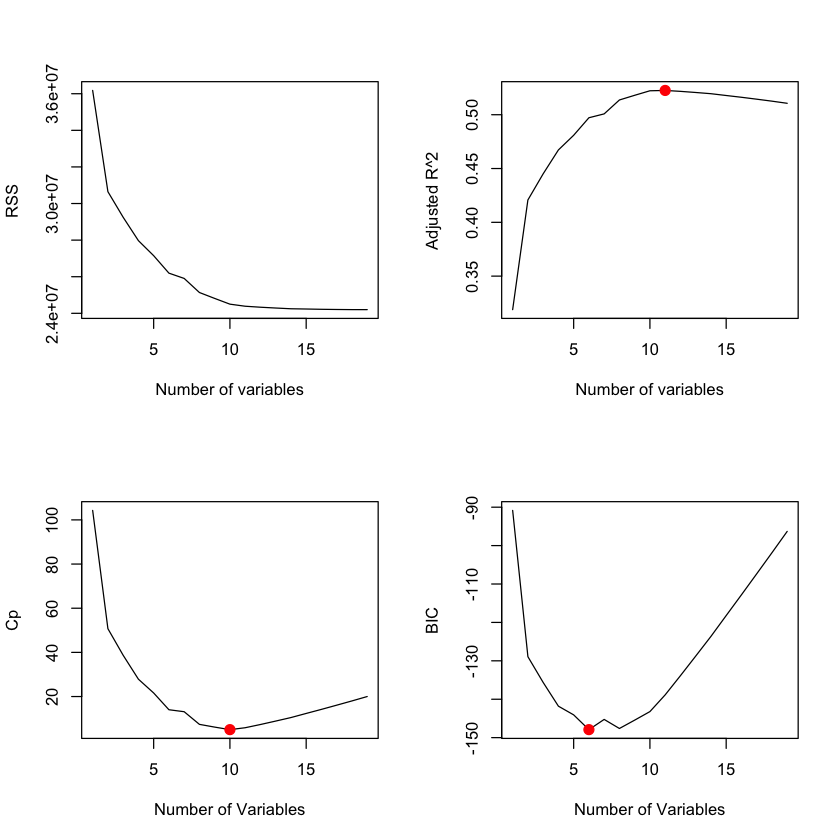

In [11]:
par(mfrow = c(2, 2))
plot(
    reg_summary$rss,
    xlab = "Number of variables",
    ylab = "RSS",
    type = "l",
)
plot(
    reg_summary$adjr2,
    xlab = "Number of variables",
    ylab = "Adjusted R^2",
    type = "l",
)

a <- which.max(reg_summary$adjr2)

points(a, reg_summary$adjr2[a],
    col = "red", cex = 2,
    pch = 20
)

plot(
    reg_summary$cp,
    xlab = "Number of Variables",
    ylab = "Cp",
    type = "l"
)

b <- which.min(reg_summary$cp)

points(b, reg_summary$cp[b],
       col = "red", cex = 2, pch = 20)

c <- which.min(reg_summary$bic)

plot(
    reg_summary$bic, 
    xlab = "Number of Variables",
    ylab = "BIC", type = "l")

points(c, reg_summary$bic[c],
    col = "red", cex = 2, pch = 20
)

The `regsubsets()` function has a built-in `plot()` command which can be used to display the selected variables for the best model with a given number of predictors, ranked according to the BIC, $C_p$, adjusted $R^2$, or AIC. 
To find out more about this function, type `?plot.regsubsets`.

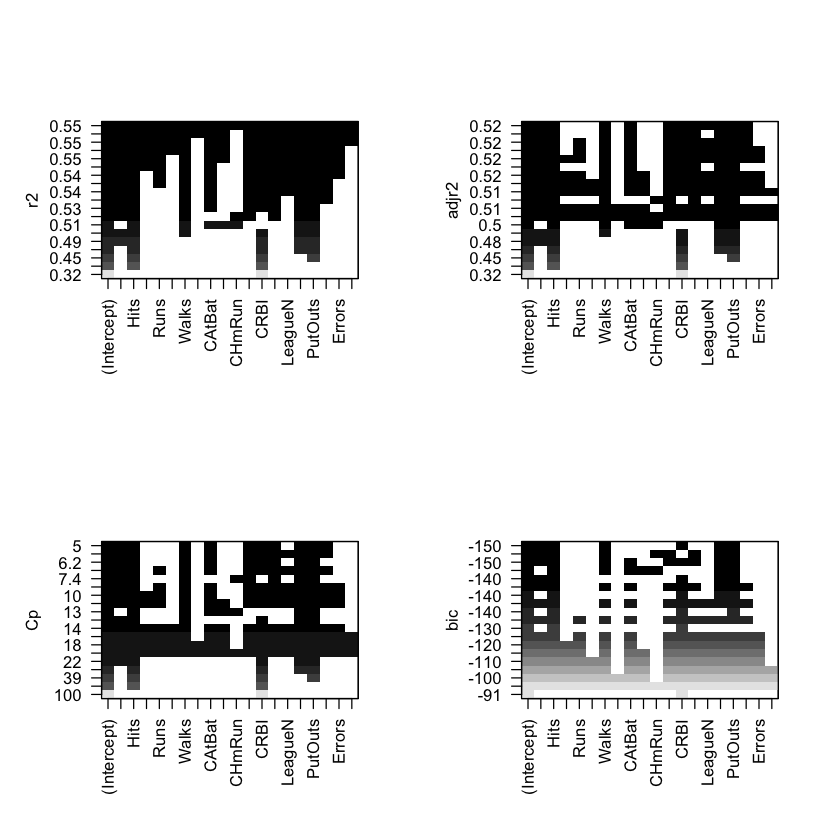

In [12]:
par(mfrow = c(2, 2), mar = c(0.5, 0.5, 0.5, 0.5))
plot(reg_fit_full, scale = "r2")
plot(reg_fit_full, scale = "adjr2")
plot(reg_fit_full, scale = "Cp")
plot(reg_fit_full, scale = "bic")

The top row of each plot contains a black square for each variable selected according to the optimal model associated with that statistic. 
For instance, we see that several models share a BIC close to −150. 
However, the model with the lowest BIC is the six-variable model that contains only `AtBat`, `Hits`, `Walks`, `CRBI`, `DivisionW`, and `PutOuts`. 
We can use the `coef()` function to see the coefficient estimates associated with this model.

In [13]:
print(coef(reg_fit_full, 6))

 (Intercept)        AtBat         Hits        Walks         CRBI    DivisionW 
  91.5117981   -1.8685892    7.6043976    3.6976468    0.6430169 -122.9515338 
     PutOuts 
   0.2643076 


### Forward and Backward Stepwise Selection

We can also use the `regsubsets()` function to perform forward stepwise or backward stepwise selection, using the argument `method = "forward"` or `method = "backward"`.

In [14]:
reg_fit_fwd <- regsubsets(
    Salary ~ .,
    data = Hitters,
    nvmax = 19,
    method = "forward"
)
summary(reg_fit_fwd)

Subset selection object
Call: regsubsets.formula(Salary ~ ., data = Hitters, nvmax = 19, method = "forward")
19 Variables  (and intercept)
           Forced in Forced out
AtBat          FALSE      FALSE
Hits           FALSE      FALSE
HmRun          FALSE      FALSE
Runs           FALSE      FALSE
RBI            FALSE      FALSE
Walks          FALSE      FALSE
Years          FALSE      FALSE
CAtBat         FALSE      FALSE
CHits          FALSE      FALSE
CHmRun         FALSE      FALSE
CRuns          FALSE      FALSE
CRBI           FALSE      FALSE
CWalks         FALSE      FALSE
LeagueN        FALSE      FALSE
DivisionW      FALSE      FALSE
PutOuts        FALSE      FALSE
Assists        FALSE      FALSE
Errors         FALSE      FALSE
NewLeagueN     FALSE      FALSE
1 subsets of each size up to 19
Selection Algorithm: forward
          AtBat Hits HmRun Runs RBI Walks Years CAtBat CHits CHmRun CRuns CRBI
1  ( 1 )  " "   " "  " "   " "  " " " "   " "   " "    " "   " "    " "   "*" 
2 

In [15]:
reg_fit_bwd <- regsubsets(
    Salary ~ .,
    data = Hitters,
    nvmax = 19,
    method = "backward"
)
summary(reg_fit_bwd)

Subset selection object
Call: regsubsets.formula(Salary ~ ., data = Hitters, nvmax = 19, method = "backward")
19 Variables  (and intercept)
           Forced in Forced out
AtBat          FALSE      FALSE
Hits           FALSE      FALSE
HmRun          FALSE      FALSE
Runs           FALSE      FALSE
RBI            FALSE      FALSE
Walks          FALSE      FALSE
Years          FALSE      FALSE
CAtBat         FALSE      FALSE
CHits          FALSE      FALSE
CHmRun         FALSE      FALSE
CRuns          FALSE      FALSE
CRBI           FALSE      FALSE
CWalks         FALSE      FALSE
LeagueN        FALSE      FALSE
DivisionW      FALSE      FALSE
PutOuts        FALSE      FALSE
Assists        FALSE      FALSE
Errors         FALSE      FALSE
NewLeagueN     FALSE      FALSE
1 subsets of each size up to 19
Selection Algorithm: backward
          AtBat Hits HmRun Runs RBI Walks Years CAtBat CHits CHmRun CRuns CRBI
1  ( 1 )  " "   " "  " "   " "  " " " "   " "   " "    " "   " "    "*"   " " 


For instance, we see that using forward stepwise selection, the best one-variable model contains only `CRBI`, and the best two-variable model additionally includes `Hits`. 
For this data, the best one-variable through six-variable models are each identical for best subset and forward selection. 
However, the best seven-variable models identified by forward stepwise selection, backward stepwise selection, and best subset selection are different.

In [16]:
print(coef(reg_fit_full, 7))

 (Intercept)         Hits        Walks       CAtBat        CHits       CHmRun 
  79.4509472    1.2833513    3.2274264   -0.3752350    1.4957073    1.4420538 
   DivisionW      PutOuts 
-129.9866432    0.2366813 


In [17]:
print(coef(reg_fit_fwd, 7))

 (Intercept)        AtBat         Hits        Walks         CRBI       CWalks 
 109.7873062   -1.9588851    7.4498772    4.9131401    0.8537622   -0.3053070 
   DivisionW      PutOuts 
-127.1223928    0.2533404 


In [18]:
print(coef(reg_fit_bwd, 7))

 (Intercept)        AtBat         Hits        Walks        CRuns       CWalks 
 105.6487488   -1.9762838    6.7574914    6.0558691    1.1293095   -0.7163346 
   DivisionW      PutOuts 
-116.1692169    0.3028847 


### Choosing Among Models Using the Validation-Set Approach and Cross-Validation

We just saw that it is possible to choose among a set of models of different sizes using $C_p$, BIC, and adjusted $R^2$. 
We will now consider how to do this using the validation set and cross-validation approaches.

**In order for these approaches to yield accurate estimates of the test error, we must use only the training observations to perform all aspects of model-fitting—including variable selection**.
Therefore, the determination of which model of a given size is best must be made using only the training observations. 
This point is subtle but important. 
If the full data set is used to perform the best subset selection step, the validation set errors and cross-validation errors that we obtain will not be accurate estimates of the test error.

In order to use the validation set approach, we begin by splitting the observations into a training set and a test set. 
We do this by creating a random vector, train, of elements equal to `TRUE` if the corresponding observation is in the training set, and `FALSE` otherwise. 
The vector test has a `TRUE` if the observation is in the test set, and a `FALSE` otherwise. 
Note the `!` in the command to create test causes `TRUE`s to be switched to `FALSE`s and vice versa. 
We also set a random seed so that the user will obtain the same training set/test set split.

For clasification problems, it is better to use `createDataPartition` from the `caret` package, as it ensure the stratification of the reponse variable in both sets.

In [19]:
set.seed(1)
train <- sample(c(T, F), nrow(Hitters), replace = T)
test <- (!train)

Now, we apply `regsubsets()` to the training set in order to perform best subset selection.

In [20]:
reg_fit_best <- regsubsets(
    Salary ~ .,
    data = Hitters[train, ],
    nvmax = 19
)

Notice that we subset the `Hitters` data frame directly in the call in order to access only the training subset of the data, using the expression `Hitters[train, ]`. 
We now compute the validation set error for the best model of each model size. 
We first make a model matrix from the test data.

In [21]:
test_mat <- model.matrix(Salary ~ ., data = Hitters[test, ])

The `model.matrix()` function is used in many regression packages for building an "X" matrix from data. 
Now we run a loop, and for each size `i`, we extract the coefficients from `regfit.best` for the best model of that size, multiply them into the appropriate columns of the test model matrix to form the predictions, and compute the test MSE.

In [22]:
NUM_MODELS <- 19
val_errors <- numeric(length = NUM_MODELS)
for (i in seq(NUM_MODELS)) {
    coef_i <- coef(reg_fit_best, id = i)
    pred <- test_mat[, names(coef_i)] %*% coef_i
    val_errors[i] <- mean((Hitters$Salary[test] - pred)^2)
}


We find that the best model is the one that contains seven variables.

In [23]:
print(val_errors)
which.min(val_errors)

 [1] 164377.3 144405.5 152175.7 145198.4 137902.1 139175.7 126849.0 136191.4
 [9] 132889.6 135434.9 136963.3 140694.9 140690.9 141951.2 141508.2 142164.4
[17] 141767.4 142339.6 142238.2


[1] 7

In [24]:
print(coef(reg_fit_best, 7))

 (Intercept)        AtBat         Hits        Walks        CRuns       CWalks 
  67.1085369   -2.1462987    7.0149547    8.0716640    1.2425113   -0.8337844 
   DivisionW      PutOuts 
-118.4364998    0.2526925 


This was a little tedious, partly because there is no `predict()` method for `regsubsets()`. 
Since we will be using this function again, we can capture our steps above and write our own predict method.


In [25]:
predict_regsubsets <- function(obj, newdata, id, ...) {
    form <- as.formula(obj$call[[2]])
    mat <- model.matrix(form, newdata)
    coefi <- coef(obj, id = id)
    xvars <- names(coefi)
    mat[, xvars] %*% coefi
}

Our function pretty much mimics what we did above. 
The only complex part is how we extracted the formula used in the call to `regsubsets()`. 
We demonstrate how we use this function below, when we do cross-validation.

Finally, we perform best subset selection on the full data set, and select the best seven-variable model. 
It is important that we make use of the full data set in order to obtain more accurate coefficient estimates. 
Note that we perform best subset selection on the full data set and select the best seven-variable model, rather than simply using the variables that were obtained from the training set, because the best seven-variable model on the full data set may differ from the corresponding model on the training set.

In [26]:
reg_fit_best <- regsubsets(Salary ~ ., data = Hitters, nvmax = 19)
print(coef(reg_fit_best, 7))

 (Intercept)         Hits        Walks       CAtBat        CHits       CHmRun 
  79.4509472    1.2833513    3.2274264   -0.3752350    1.4957073    1.4420538 
   DivisionW      PutOuts 
-129.9866432    0.2366813 


In fact, we see that the best seven-variable model on the full data set has a different set of variables than the best seven-variable model on the training set.

We now try to choose among the models of different sizes using cross-validation. 
This approach is somewhat involved, as we must perform best subset selection within each of the $k$ training sets. Despite this, we see that with its clever subsetting syntax, `R` makes this job quite easy. 
First, we create a vector that allocates each observation to one of $k = 10$ folds, and we create a matrix in which we will store the results.

In [27]:
k <- 10
n <- nrow(Hitters)
set.seed(1)
folds <- sample(rep(1:k, length = n))
cv_errors <- matrix(NA, k, 19, dimnames = list(NULL, paste(1:19)))

Now we write a for loop that performs cross-validation. 
In the $j$-th fold, the elements of folds that equal $j$ are in the test set, and the remainder are in the training set. 
We make our predictions for each model size (using our new `predict_regsubsets()` method), compute the test errors on the appropriate subset, and store them in the appropriate slot in the matrix `cv.errors`. 
Note that in the following code `R` will automatically use our `predict.regsubsets()` function when we call `predict()` because the `best.fit` object has class regsubsets.

In [28]:
for (j in seq(k)) {
    best_fit <- regsubsets(
        Salary ~ .,
        data = Hitters[folds != j, ],
        nvmax = 19
    )
    for (i in seq(19)) {
        pred <- predict_regsubsets(best_fit, Hitters[folds == j, ], id = i)
        cv_errors[j, i] <- mean((Hitters$Salary[folds == j] - pred)^2)
    }
}

This has given us a $10\times 19$ matrix, of which the $(j, i)$-th element corresponds to the test MSE for the $j$-th cross-validation fold for the best $i$-variable model. 
We use the `apply()` function to average over the columns of this matrix in order to obtain a vector for which the ith element is the cross-validation error for the $i$-variable model.

In [29]:
mean_cv_errors <- apply(cv_errors, 2, mean)
print(mean_cv_errors)

       1        2        3        4        5        6        7        8 
143439.8 126817.0 134214.2 131782.9 130765.6 120382.9 121443.1 114363.7 
       9       10       11       12       13       14       15       16 
115163.1 109366.0 112738.5 113616.5 115557.6 115853.3 115630.6 116050.0 
      17       18       19 
116117.0 116419.3 116299.1 


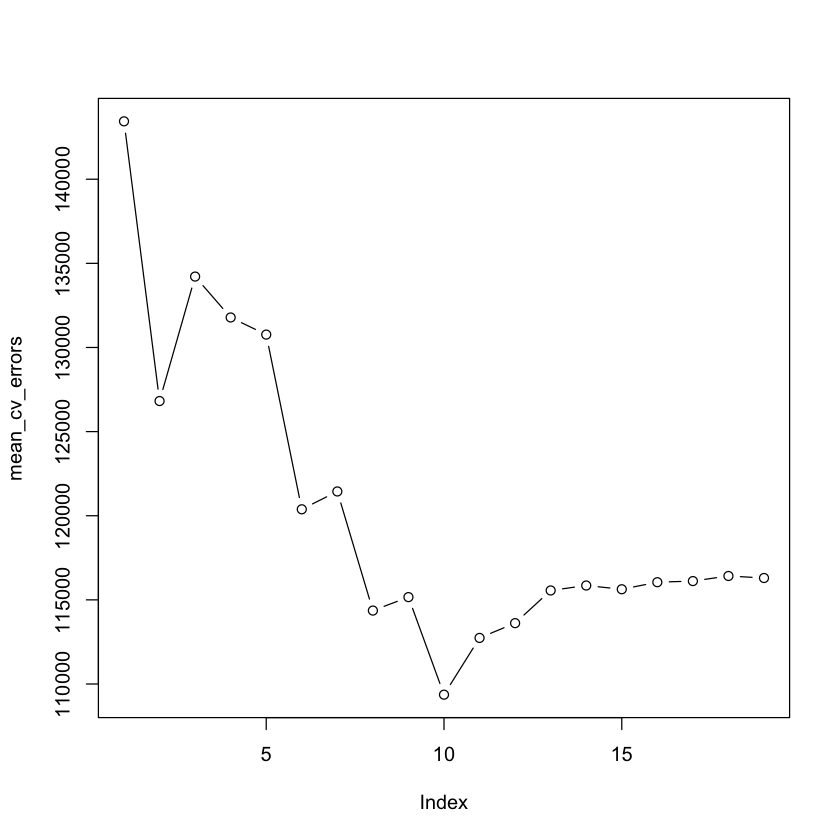

In [30]:
plot(mean_cv_errors, type = "b")

We see that cross-validation selects a 10-variable model. 
We now perform best subset selection on the full data set in order to obtain the 10-variable model.
(This would be the `refit=true` option in the `sklearn` package)

In [31]:
reg_best_cv <- regsubsets(Salary ~ ., data = Hitters, nvmax = 19)
print(coef(reg_best_cv, 10))

 (Intercept)        AtBat         Hits        Walks       CAtBat        CRuns 
 162.5354420   -2.1686501    6.9180175    5.7732246   -0.1300798    1.4082490 
        CRBI       CWalks    DivisionW      PutOuts      Assists 
   0.7743122   -0.8308264 -112.3800575    0.2973726    0.2831680 


## 6.5.2 Ridge Regression and the Lasso

We will use the `glmnet` package in order to perform ridge regression and the lasso. 
The main function in this package is `glmnet()`, which can be used to fit ridge regression models, lasso models, and more. 
This function has slightly different syntax from other model-fitting functions that we have encountered thus far in this book. 
In particular, we must pass in an `X` matrix as well as a `y` vector, and we do not use the `y ~ x` syntax. 
We will now perform ridge regression and the lasso in order to predict `Salary` on the `Hitters` data. 
Before proceeding ensure that the missing values have been removed from the data, as described in Section 6.5.1.

In [32]:
X <- model.matrix(Salary ~ ., Hitters)[, -1]
y <- Hitters$Salary

The `model.matrix()` function is particularly useful for creating $X$; not only does it produce a matrix corresponding to the 19 predictors but it also automatically transforms any qualitative variables into dummy variables. 
The latter property is important because `glmnet()` can only take numerical, quantitative inputs.

### Ridge Regression

The `glmnet()` function has an alpha argument that determines what type of model is fit. 
If `alpha=0` then a ridge regression model is fit, and if `alpha=1` then a lasso model is fit. 
We first fit a ridge regression model.

In [33]:
lambda_grid <- 10^seq(10, -2, length = 100)

In [34]:
ridge_mod <- glmnet(X, y, alpha = 0, lambda = lambda_grid)

By default the `glmnet()` function performs ridge regression for an automatically selected range of $\lambda$ values. However, here we have chosen to implement the function over a grid of values ranging from $\lambda = 1010$ to $10^{−2}$, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit. 
As we will see, we can also compute model fits for a particular value of $\lambda$ that is not one of the original grid values. 
**Note that by default, the `glmnet()` function standardizes the variables so that they are on the same scale**. 
To turn off this default setting, use the argument `standardize = FALSE`.

Associated with each value of $\lambda$ is a vector of ridge regression coefficients, stored in a matrix that can be accessed by `coef()`. 
In this case, it is a $20\times 100$ matrix, with 20 rows (one for each predictor, plus an intercept) and 100 columns (one for each value of $\lambda$).

In [35]:
dim(coef(ridge_mod))

[1]  20 100

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm, when a large value of $\lambda$ is used, as compared to when a small value of $\lambda$ is used. 
These are the coefficients when $\lambda = 11498$, along with their $l_2$ norm:

In [36]:
ridge_mod$lambda[50]

[1] 11497.57

In [37]:
print(coef(ridge_mod)[, 50])

  (Intercept)         AtBat          Hits         HmRun          Runs 
407.356050200   0.036957182   0.138180344   0.524629976   0.230701523 
          RBI         Walks         Years        CAtBat         CHits 
  0.239841459   0.289618741   1.107702929   0.003131815   0.011653637 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
  0.087545670   0.023379882   0.024138320   0.025015421   0.085028114 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
 -6.215440973   0.016482577   0.002612988  -0.020502690   0.301433531 


In [38]:
sqrt(sum(coef(ridge_mod)[-1, 50]^2)) # l2 norm

[1] 6.360612

In contrast, here are the coefficients when $\lambda = 705$, along with their $l_2$ norm. 
Note the much larger $l_2$ norm of the coefficients associated with this smaller value of $\lambda$.

In [39]:
ridge_mod$lambda[60]

[1] 705.4802

In [40]:
print(coef(ridge_mod)[, 60])

 (Intercept)        AtBat         Hits        HmRun         Runs          RBI 
 54.32519950   0.11211115   0.65622409   1.17980910   0.93769713   0.84718546 
       Walks        Years       CAtBat        CHits       CHmRun        CRuns 
  1.31987948   2.59640425   0.01083413   0.04674557   0.33777318   0.09355528 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
  0.09780402   0.07189612  13.68370191 -54.65877750   0.11852289   0.01606037 
      Errors   NewLeagueN 
 -0.70358655   8.61181213 


In [41]:
sqrt(sum(coef(ridge_mod)[-1, 60]^2)) # l2 norm

[1] 57.11001

We can use the `predict()` function for a number of purposes. 
For instance, we can obtain the ridge regression coefficients for a new value of $\lambda$, say 50:

In [42]:
print(predict(ridge_mod, s = 50, type = "coefficients")[1:20, ])

  (Intercept)         AtBat          Hits         HmRun          Runs 
 4.876610e+01 -3.580999e-01  1.969359e+00 -1.278248e+00  1.145892e+00 
          RBI         Walks         Years        CAtBat         CHits 
 8.038292e-01  2.716186e+00 -6.218319e+00  5.447837e-03  1.064895e-01 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
 6.244860e-01  2.214985e-01  2.186914e-01 -1.500245e-01  4.592589e+01 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
-1.182011e+02  2.502322e-01  1.215665e-01 -3.278600e+00 -9.496680e+00 


We now split the samples into a training set and a test set in order to estimate the test error of ridge regression and the lasso. 
There are two common ways to randomly split a data set.
The first is to produce a random vector of `TRUE`, `FALSE` elements and select the observations corresponding to `TRUE` for the training data. 
The second is to randomly choose a subset of numbers between $1$ and $n$; these can then be used as the indices for the training observations. 
The two approaches work equally well. 
We used the former method in Section 6.5.1. 
Here we demonstrate the latter approach.
We first set a random seed so that the results obtained will be reproducible.

In [43]:
set.seed(1)
train <- sample(1:nrow(X), nrow(X) / 2)
test <- (-train)
y_test <- y[test]

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using $\lambda = 4$. Note the use of the `predict()` function again. 
This time we get predictions for a test set, by replacing `type="coefficients"` with the `newx` argument.


In [44]:
ridge_mod <- glmnet(
    X[train, ],
    y[train],
    alpha = 0,
    lambda = lambda_grid,
    thresh = 1e-12
)

In [45]:
ridge_pred <- predict(ridge_mod, s = 4, newx = X[test, ])
mean((ridge_pred - y_test)^2)

[1] 142199.2

The test MSE is 142199. 
Note that if we had instead simply fit a model with just an intercept, we would have predicted each test observation using the mean of the training observations. 
In that case, we could compute the test set MSE like this:

In [46]:
mean((mean(y[train]) - y_test)^2)

[1] 224669.9

We could also get the same result by fitting a ridge regression model with a very large value of $\lambda$. 
Note that `1e10` means $10^{10}$.

In [47]:
ridge_pred <- predict(ridge_mod, s = 1e10, newx = X[test, ])
mean((ridge_pred - y_test)^2)

[1] 224669.8

So fitting a ridge regression model with $\lambda = 4$ leads to a much lower test MSE than fitting a model with just an intercept. 
We now check whether there is any benefit to performing ridge regression with $\lambda = 4$ instead of just performing least squares regression. 
Recall that least squares is simply ridge regression with $\lambda = 0$.

In [48]:
ridge_pred <- predict(
    ridge_mod,
    s = 0, # lambda
    newx = X[test, ],
    exact = T,
    x = X[train, ],
    y = y[train]
)
mean((ridge_pred - y_test)^2)

[1] 168588.6

In [49]:
lm(y ~ X, subset = train)


Call:
lm(formula = y ~ X, subset = train)

Coefficients:
(Intercept)       XAtBat        XHits       XHmRun        XRuns         XRBI  
   274.0145      -0.3521      -1.6377       5.8145       1.5424       1.1243  
     XWalks       XYears      XCAtBat       XCHits      XCHmRun       XCRuns  
     3.7287     -16.3773      -0.6412       3.1632       3.4008      -0.9739  
      XCRBI      XCWalks     XLeagueN   XDivisionW     XPutOuts     XAssists  
    -0.6005       0.3379     119.1486    -144.0831       0.1976       0.6804  
    XErrors  XNewLeagueN  
    -4.7128     -71.0951  


In [50]:
print(predict(ridge_mod,
    s = 0, exact = T, type = "coefficients",
    x = X[train, ], y = y[train]
)[1:20, ])

 (Intercept)        AtBat         Hits        HmRun         Runs          RBI 
 274.0200994   -0.3521900   -1.6371383    5.8146692    1.5423361    1.1241837 
       Walks        Years       CAtBat        CHits       CHmRun        CRuns 
   3.7288406  -16.3795195   -0.6411235    3.1629444    3.4005281   -0.9739405 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
  -0.6003976    0.3378422  119.1434637 -144.0853061    0.1976300    0.6804200 
      Errors   NewLeagueN 
  -4.7127879  -71.0898914 


In general, if we want to fit a (unpenalized) least squares model, then we should use the `lm()` function, since that function provides more useful outputs, such as standard errors and $p$-values for the coefficients.

In general, instead of arbitrarily choosing $\lambda = 4$, it would be better to use cross-validation to choose the tuning parameter $\lambda$. 
We can do this using the built-in cross-validation function, `cv.glmnet()`. 
By default, the function performs ten-fold cross-validation, though this can be changed using the argument `nfolds`. Note that we set a random seed first so our results will be reproducible, since the choice of the cross-validation folds is random.

In [51]:
set.seed(1)
cv_out <- cv.glmnet(X[train, ], y[train], alpha = 0)

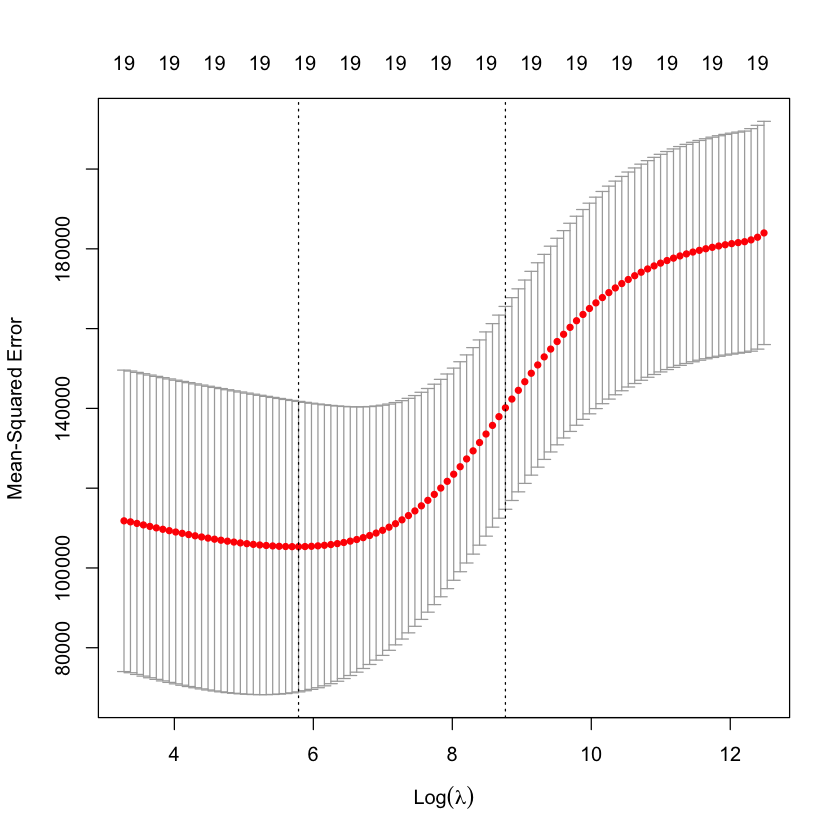

In [52]:
plot(cv_out)

In [53]:
best_lambda <- cv_out$lambda.min
best_lambda

[1] 326.0828

Therefore, we see that the value of $\lambda$ that results in the smallest cross-validation error is 326. 
What is the test MSE associated with this value of $\lambda$?

In [54]:
ridge_pred <- predict(ridge_mod, s = best_lambda, newx = X[test, ])
mean((ridge_pred - y_test)^2)

[1] 139856.6

This represents a further improvement over the test MSE that we got using $\lambda = 4$. 
Finally, we refit our ridge regression model on the full data set, using the value of $\lambda$ chosen by cross-validation, and examine the coefficient estimates.

In [55]:
out <- glmnet(X, y, alpha = 0)
print(predict(out, type = "coefficients", s = best_lambda)[1:20, ])

 (Intercept)        AtBat         Hits        HmRun         Runs          RBI 
 15.44383135   0.07715547   0.85911581   0.60103107   1.06369007   0.87936105 
       Walks        Years       CAtBat        CHits       CHmRun        CRuns 
  1.62444616   1.35254780   0.01134999   0.05746654   0.40680157   0.11456224 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
  0.12116504   0.05299202  22.09143189 -79.04032637   0.16619903   0.02941950 
      Errors   NewLeagueN 
 -1.36092945   9.12487767 


As expected, none of the coefficients are zero—ridge regression does not perform variable selection!

### The Lasso

We saw that ridge regression with a wise choice of $\lambda$ can outperform least squares as well as the null model on the `Hitters` data set. 
We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. 
In order to fit a lasso model, we once again use the `glmnet()` function; however, this time we use the argument `alpha=1`. 
Other than that change, we proceed just as we did in fitting a ridge model.

In [56]:
lasso_mod <- glmnet(
    X[train, ],
    y[train],
    alpha = 1,
    lambda = lambda_grid
)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


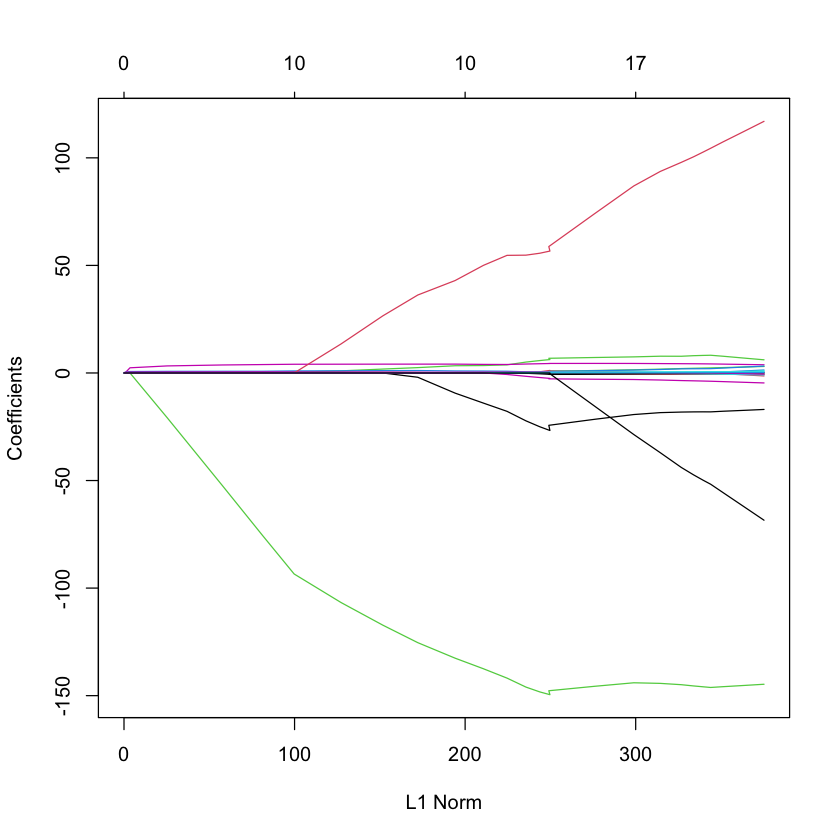

In [57]:
plot(lasso_mod)

We can see from the coefficient plot that depending on the choice of tuning parameter, some of the coefficients will be exactly equal to zero. 
We now perform cross-validation and compute the associated test error.

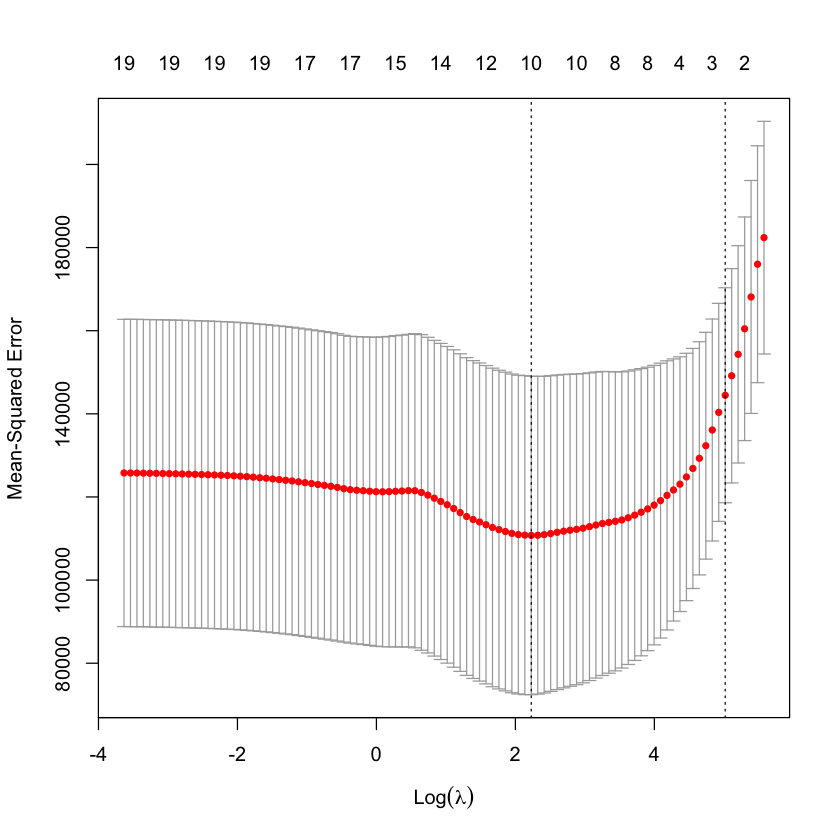

In [58]:
set.seed(1)
cv_out <- cv.glmnet(X[train, ], y[train], alpha = 1)
plot(cv_out)

In [59]:
best_lambda <- cv_out$lambda.min
best_lambda

[1] 9.286955

In [60]:
lasso_pred <- predict(
    lasso_mod,
    s = best_lambda,
    newx = X[test, ]
)
mean((lasso_pred - y_test)^2)

[1] 143673.6

This is substantially lower than the test set MSE of the null model and of least squares, and very similar to the test MSE of ridge regression with $\lambda$ chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in that the resulting coefficient estimates are sparse. 
Here we see that 8 of the 19 coefficient estimates are exactly zero. 
So the lasso model with $\lambda$ chosen by cross-validation contains only eleven variables.

In [61]:
out <- glmnet(X, y, alpha = 1, lambda = lambda_grid)
lasso_coef <- predict(out, type = "coefficients", s = best_lambda)[1:20, ]
print(lasso_coef)

  (Intercept)         AtBat          Hits         HmRun          Runs 
   1.27479059   -0.05497143    2.18034583    0.00000000    0.00000000 
          RBI         Walks         Years        CAtBat         CHits 
   0.00000000    2.29192406   -0.33806109    0.00000000    0.00000000 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
   0.02825013    0.21628385    0.41712537    0.00000000   20.28615023 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
-116.16755870    0.23752385    0.00000000   -0.85629148    0.00000000 


In [62]:
print(lasso_coef[lasso_coef != 0])

  (Intercept)         AtBat          Hits         Walks         Years 
   1.27479059   -0.05497143    2.18034583    2.29192406   -0.33806109 
       CHmRun         CRuns          CRBI       LeagueN     DivisionW 
   0.02825013    0.21628385    0.41712537   20.28615023 -116.16755870 
      PutOuts        Errors 
   0.23752385   -0.85629148 


## 6.5.3 PCR and PLS Regression

### Principal Components Regression

Principal components regression (PCR) can be performed using the `pcr()` function, which is part of the `pls` library.We now apply PCR to the `Hitters` data, in order to predict `Salary`. 
Again, we ensure that the missing values have been removed from the data, as described in Section 6.5.1.

In [66]:
set.seed(2)
pcr_fit <- pcr(
    Salary ~ .,
    data = Hitters,
    scale = TRUE,
    validation = "CV"
)

The syntax for the `pcr()` function is similar to that for `lm()`, with a few additional options. 
Setting `scale = TRUE` has the effect of standardizing each predictor, using (6.6), prior to generating the principal components, so that the scale on which each variable is measured will not have an effect. 
Setting `validation = "CV"` causes `pcr()` to compute the ten-fold cross-validation error for each possible value of $M$, the number of principal components used. 
The resulting fit can be examined using `summary()`.

In [67]:
summary(pcr_fit)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: svdpc
Number of components considered: 19

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV             452    351.9    353.2    355.0    352.8    348.4    343.6
adjCV          452    351.6    352.7    354.4    352.1    347.6    342.7
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV       345.5    347.7    349.6     351.4     352.1     353.5     358.2
adjCV    344.7    346.7    348.5     350.1     350.7     352.0     356.5
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps
CV        349.7     349.4     339.9     341.6     339.2     339.6
adjCV     348.0     347.7     338.2     339.7     337.2     337.6

TRAINING: % variance explained
        1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X         38.31    60.16    70.84    79.03    84.29    88.63    92.26    94.96
Salary    4

The CV score is provided for each possible number of components, ranging from $M = 0$ onwards. 
Note that `pcr()` reports the root mean squared error; in order to obtain the usual MSE, we must square this quantity. 
For instance, a root mean squared error of 352.8 corresponds to an MSE of 352.8$^2$ = 124468.

One can also plot the cross-validation scores using the `validationplot()` function. 
Using `val.type = "MSEP"` will cause the cross-validation MSE to be plotted.

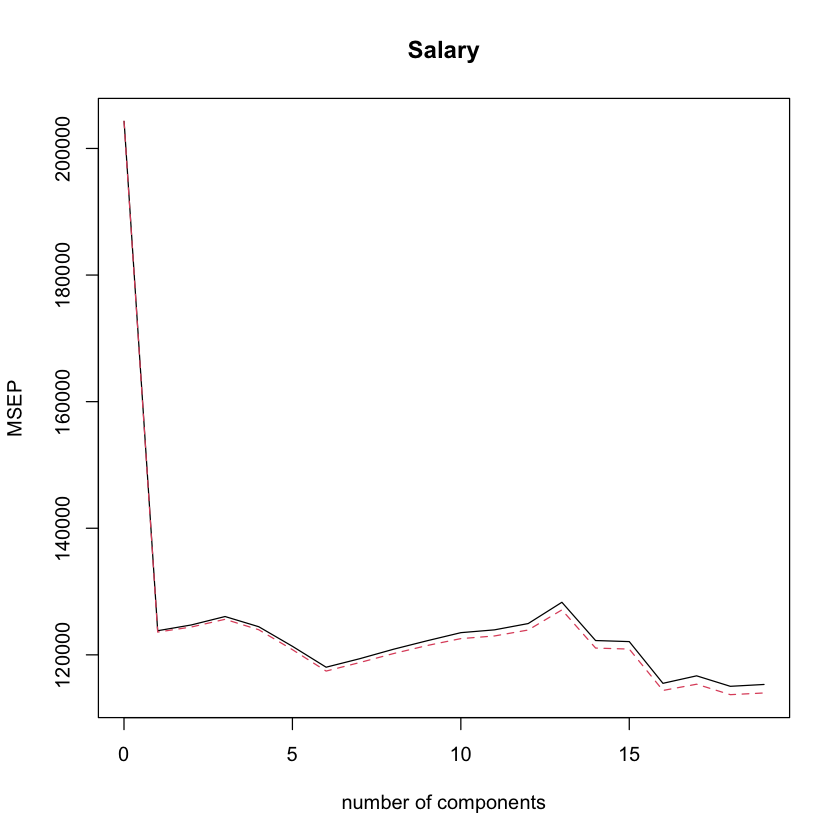

In [68]:
validationplot(pcr_fit, val.type = "MSEP")


We see that the smallest cross-validation error occurs when $M = 18$ components are used. 
This is barely fewer than $M = 19$, which amounts to simply performing least squares, because when all of the components are used in PCR no dimension reduction occurs. 
However, from the plot we also see that the cross-validation error is roughly the same when only one component is included in the model. 
This suggests that a model that uses just a small number of components might suffice.

The `summary()` function also provides the percentage of variance explained in the predictors and in the response using different numbers of components. 
This concept is discussed in greater detail in Chapter 12. 
Briefly, we can think of this as the amount of information about the predictors or the response that is captured using $M$ principal components. 
For example, setting $M = 1$ only captures 38.31% of all the variance, or information, in the predictors. 
In contrast, using $M = 5$ increases the value to 84.29%. 
If we were to use all $M = p = 19$ components, this would increase to 100%.

We now perform PCR on the training data and evaluate its test set performance.


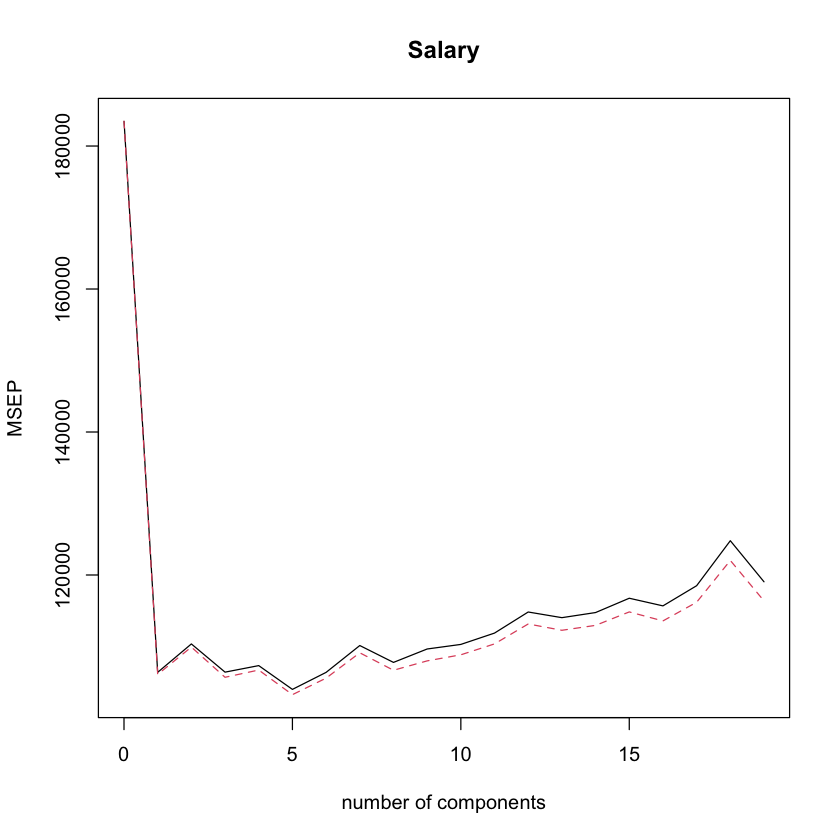

In [69]:
set.seed(1)
pcr_fit <- pcr(
    Salary ~ .,
    data = Hitters,
    subset = train,
    scale = TRUE,
    validation = "CV"
)

validationplot(pcr_fit, val.type = "MSEP")

Now we find that the lowest cross-validation error occurs when $M = 5$ components are used. 
We compute the test MSE as follows.

In [70]:
pcr_pred <- predict(pcr_fit, X[test, ], ncomp = 5)
mean((pcr_pred - y_test)^2)

[1] 142811.8

This test set MSE is competitive with the results obtained using ridge regression and the lasso. 
However, as a result of the way PCR is implemented, the final model is more difficult to interpret because it does not perform any kind of variable selection or even directly produce coefficient estimates.

Finally, we fit PCR on the full data set, using $M = 5$, the number of components identified by cross-validation.

In [71]:
pcr_fit <- pcr(
    y ~ X,
    scale = TRUE,
    ncomp = 5
)
summary(pcr_fit)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: svdpc
Number of components considered: 5
TRAINING: % variance explained
   1 comps  2 comps  3 comps  4 comps  5 comps
X    38.31    60.16    70.84    79.03    84.29
y    40.63    41.58    42.17    43.22    44.90


### Partial Least Squares

We implement partial least squares (PLS) using the `plsr()` function, also in the `pls` library. 
The syntax is just like that of the `pcr()` function.

In [75]:
set.seed(1)
pls_fit <- plsr(
    Salary ~ .,
    data = Hitters,
    scale = TRUE,
    subset = train,
    validation = "CV"
)

summary(pls_fit)

Data: 	X dimension: 131 19 
	Y dimension: 131 1
Fit method: kernelpls
Number of components considered: 19

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           428.3    325.5    329.9    328.8    339.0    338.9    340.1
adjCV        428.3    325.0    328.2    327.2    336.6    336.1    336.6
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV       339.0    347.1    346.4     343.4     341.5     345.4     356.4
adjCV    336.2    343.4    342.8     340.2     338.3     341.8     351.1
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps
CV        348.4     349.1     350.0     344.2     344.5     345.0
adjCV     344.2     345.0     345.9     340.4     340.6     341.1

TRAINING: % variance explained
        1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X         39.13    48.80    60.09    75.07    78.58    81.12    88.21    90.71
Salary 

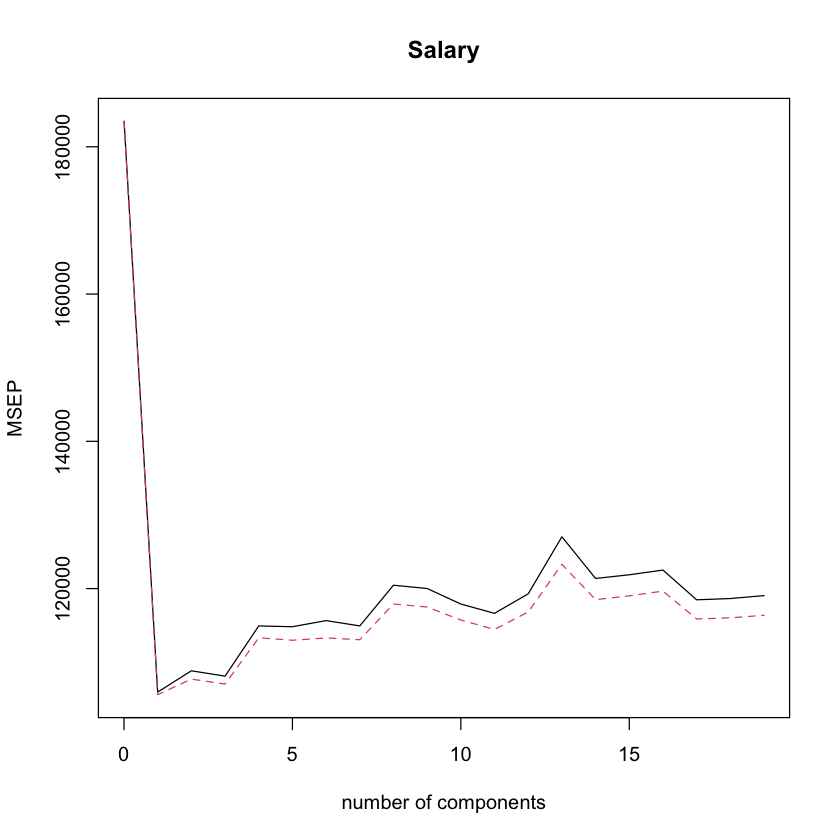

In [76]:
validationplot(pls_fit, val.type = "MSEP")

The lowest cross-validation error occurs when only $M = 1$ partial least squares directions are used. 
We now evaluate the corresponding test set MSE.

In [78]:
pls_pred <- predict(pls_fit, X[test, ], ncomp = 1)
mean((pls_pred - y_test)^2)

[1] 151995.3

The test MSE is comparable to, but slightly higher than, the test MSE obtained using ridge regression, the lasso, and PCR.

Finally, we perform PLS using the full data set, using $M = 1$, the number of components identified by cross-validation.

In [79]:
pls_fit <- plsr(Salary ~ ., data = Hitters, scale = TRUE, ncomp = 1)
summary(pls_fit)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: kernelpls
Number of components considered: 1
TRAINING: % variance explained
        1 comps
X         38.08
Salary    43.05


**Notice that the percentage of variance in `Salary` that the one-component PLS fit explains, 43.05%, is almost as much as that explained using the final five-component model PCR fit, 44.90%. 
This is because PCR only attempts to maximize the amount of variance explained in the predictors, while PLS searches for directions that explain variance in both the predictors and the response.**